In [1]:
import pandas as pd
import numpy as np
import itertools
from random import randint
from datetime import datetime, date
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

## Data Cleaning

In [2]:
CustomerDemographic = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', 'CustomerDemographic', 1)
CustomerAddress = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', 'CustomerAddress', 1)
Transactions = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', 'Transactions', 1)

In [3]:
# Remove Transactions that were Cancelled
print(np.unique(Transactions.order_status, return_counts=True))
Transactions = Transactions[Transactions.order_status == 'Approved']
len(Transactions)

(array(['Approved', 'Cancelled'], dtype=object), array([19821,   179], dtype=int64))


19821

In [4]:
# Create new column to sum up purchases made by same customer
Transactions['purchases'] = np.ones(len(Transactions))
# Create prediction value based on list_price & standard_cost
Transactions['value'] = Transactions['list_price'] - Transactions['standard_cost']
trans_temp = Transactions.groupby('customer_id').agg('sum')
trans_temp.head()

,transaction_id,product_id,online_order,list_price,standard_cost,product_first_sold_date,purchases,value
customer_id,,,,,,,,
1,126342,376,6.0,9084.45,6066.36,410455.0,11.0,3018.09
2,25415,112,1.0,4149.07,1922.81,116327.0,3.0,2226.26
3,110741,483,1.0,9888.23,6525.42,314802.0,8.0,3362.81
4,27089,157,1.0,1047.72,827.15,72017.0,2.0,220.57
5,47818,289,2.0,5903.20,3508.26,224166.0,6.0,2394.94


### Merge all training data into single dataframe

In [5]:
temp = trans_temp.merge(CustomerAddress, how='inner',on='customer_id')
train = temp.merge(CustomerDemographic, how='inner',on='customer_id')
train

,customer_id,transaction_id,product_id,online_order,list_price,standard_cost,product_first_sold_date,purchases,value,address,...,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure
0,1,126342,376,6.0,9084.45,6066.36,410455.0,11.0,3018.09,060 Morning Avenue,...,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0
1,2,25415,112,1.0,4149.07,1922.81,116327.0,3.0,2226.26,6 Meadow Vale Court,...,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0
2,4,27089,157,1.0,1047.72,827.15,72017.0,2.0,220.57,0 Holy Cross Court,...,Male,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0
3,5,47818,289,2.0,5903.20,3508.26,224166.0,6.0,2394.94,17979 Del Mar Point,...,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0
4,6,25964,143,2.0,5931.69,1985.14,194209.0,5.0,3946.55,9 Oakridge Court,...,Male,35,1966-09-16,NaN,Retail,High Net Worth,N,ðµ ð ð ð,Yes,13.0
5,7,40872,99,2.0,995.38,775.27,118161.0,3.0,220.11,4 Delaware Trail,...,Female,6,1976-02-23,NaN,Financial Services,Affluent Customer,N,â°â´âµâââ,Yes,11.0
6,8,110224,274,5.0,12024.76,4957.82,392332.0,10.0,7066.94,49 Londonderry Lane,...,Male,31,1962-03-30,Media Manager I,NaN,Mass Customer,N,(â¯Â°â¡Â°ï¼â¯ï¸µ â»ââ»),No,7.0
7,9,38371,293,1.0,5357.55,3004.44,242834.0,6.0,2353.11,97736 7th Trail,...,Female,97,1973-03-10,Business Systems Development Analyst,Argiculture,Affluent Customer,N,0/0,Yes,8.0
8,11,75783,167,2.0,6779.44,3140.60,231200.0,6.0,3638.84,93405 Ludington Park,...,Male,99,1954-04-30,NaN,Property,Mass Customer,N,ÅâÂ´Â®â Â¥Â¨ËÃ¸Ïââ,No,9.0
9,12,78960,380,3.0,6394.21,2854.18,273948.0,7.0,3540.03,44339 Golden Leaf Alley,...,Male,58,1994-07-21,Nuclear Power Engineer,Manufacturing,Mass Customer,N,nil,No,8.0


In [6]:
# Convert DOB to Age
age = [pd.to_datetime('today').year - pd.to_datetime(i).year for i in train.DOB]
train['age'] = age
# Standardize inputs in state column
train.loc[train['state']=='New South Wales','state'] = 'NSW'
train.loc[train['state']=='Victoria','state'] = 'VIC'
# Standardize inputs in gender column
train.loc[train['gender']=='F','gender'] = 'Female'
train.loc[train['gender']=='Femal','gender'] = 'Female'
train.loc[train['gender']=='M','gender'] = 'Male'
train.loc[train['gender']=='U','gender'] = 'Male'
train.head()

,customer_id,transaction_id,product_id,online_order,list_price,standard_cost,product_first_sold_date,purchases,value,address,...,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure,age
0,1,126342,376,6.0,9084.45,6066.36,410455.0,11.0,3018.09,060 Morning Avenue,...,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0,67.0
1,2,25415,112,1.0,4149.07,1922.81,116327.0,3.0,2226.26,6 Meadow Vale Court,...,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0,40.0
2,4,27089,157,1.0,1047.72,827.15,72017.0,2.0,220.57,0 Holy Cross Court,...,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0,59.0
3,5,47818,289,2.0,5903.20,3508.26,224166.0,6.0,2394.94,17979 Del Mar Point,...,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0,43.0
4,6,25964,143,2.0,5931.69,1985.14,194209.0,5.0,3946.55,9 Oakridge Court,...,35,1966-09-16,NaN,Retail,High Net Worth,N,ðµ ð ð ð,Yes,13.0,54.0


In [7]:
# Remove Transactions that were from deceased 
print(np.unique(train.deceased_indicator, return_counts=True))
train = train[train.deceased_indicator == 'N']
len(train)

(array(['N', 'Y'], dtype=object), array([3487,    1], dtype=int64))


3487

### Choose Potential Predictor columns

In [8]:
train_1 = train[['gender','age','past_3_years_bike_related_purchases','wealth_segment','owns_car','tenure','state','property_valuation','job_title','job_industry_category','value']]
train_1.isna().sum()

gender                                   0
age                                     76
past_3_years_bike_related_purchases      0
wealth_segment                           0
owns_car                                 0
tenure                                  76
state                                    0
property_valuation                       0
job_title                              421
job_industry_category                  560
value                                    0
dtype: int64

In [9]:
# Removed Nan rows as its a small portion of training data
train_1 = train_1.dropna(subset=['age','tenure','value'])
train_1.isna().sum()

gender                                   0
age                                      0
past_3_years_bike_related_purchases      0
wealth_segment                           0
owns_car                                 0
tenure                                   0
state                                    0
property_valuation                       0
job_title                              415
job_industry_category                  560
value                                    0
dtype: int64

In [10]:
np.unique(train_1.gender, return_counts=True)

(array(['Female', 'Male'], dtype=object), array([1756, 1655], dtype=int64))

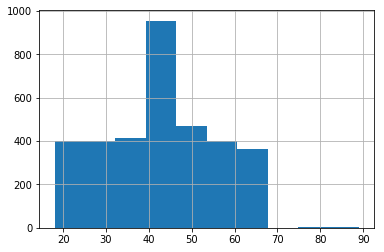

In [11]:
# Remove outlier of age=177
max_age = train_1['age'].max()
train_1 = train_1[train_1['age']<max_age]
train_1['age'].hist()

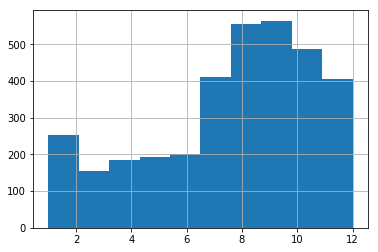

In [12]:
train_1['property_valuation'].hist()

## Categorical Data

In [13]:
train_1.loc[train_1['state']=='New South Wales','state'] = 'NSW'
train_1.loc[train_1['state']=='Victoria','state'] = 'VIC'
np.unique(train_1.state, return_counts=True)

(array(['NSW', 'QLD', 'VIC'], dtype=object),
 array([1822,  728,  860], dtype=int64))

In [14]:
from sklearn.preprocessing import LabelEncoder 
# Create labels for categories
le_gender = LabelEncoder()
train_1['gender']= le_gender.fit_transform(train_1['gender'])
le_wealth = LabelEncoder()
train_1['wealth_segment']= le_wealth.fit_transform(train_1['wealth_segment']) +1
le_owns = LabelEncoder()
train_1['owns_car']= le_owns.fit_transform(train_1['owns_car'])
le_state = LabelEncoder()
train_1['state']= le_state.fit_transform(train_1['state']) +1
train_1.head()

,gender,age,past_3_years_bike_related_purchases,wealth_segment,owns_car,tenure,state,property_valuation,job_title,job_industry_category,value
0,0,67.0,93,3,1,11.0,1,10,Executive Secretary,Health,3018.09
1,1,40.0,81,3,1,16.0,1,10,Administrative Officer,Financial Services,2226.26
2,1,59.0,33,3,0,7.0,2,9,NaN,IT,220.57
3,0,43.0,56,1,1,8.0,1,4,Senior Editor,NaN,2394.94
4,1,54.0,35,2,1,13.0,3,9,NaN,Retail,3946.55


In [15]:
# Create age bracket
age_bracket = []
for x in train_1.age:
    if x < 10:
        age_bracket.append(0)
    elif x>=10 and x<20:
        age_bracket.append(1)
    elif x>=20 and x<30:
        age_bracket.append(2)
    elif x>=30 and x<40:
        age_bracket.append(3)
    elif x>=40 and x<50:
        age_bracket.append(4)
    elif x>=50 and x<60:
        age_bracket.append(5)
    elif x>=60 and x<70:
        age_bracket.append(6)
    elif x>=70 and x<80:
        age_bracket.append(7)
    elif x>=80 and x<90:
        age_bracket.append(8)
train_1['age_bracket'] = age_bracket
train_1 = train_1.drop(columns = ['age'])

In [16]:
# Create a set of dummy variables
df_train = pd.get_dummies(train_1, columns=['job_title','job_industry_category'])
df_train.head()

,gender,past_3_years_bike_related_purchases,wealth_segment,owns_car,tenure,state,property_valuation,value,age_bracket,job_title_Account Coordinator,...,job_title_Web Developer IV,job_industry_category_Argiculture,job_industry_category_Entertainment,job_industry_category_Financial Services,job_industry_category_Health,job_industry_category_IT,job_industry_category_Manufacturing,job_industry_category_Property,job_industry_category_Retail,job_industry_category_Telecommunications
0,0,93,3,1,11.0,1,10,3018.09,6,0,...,0,0,0,0,1,0,0,0,0,0
1,1,81,3,1,16.0,1,10,2226.26,4,0,...,0,0,0,1,0,0,0,0,0,0
2,1,33,3,0,7.0,2,9,220.57,5,0,...,0,0,0,0,0,1,0,0,0,0
3,0,56,1,1,8.0,1,4,2394.94,4,0,...,0,0,0,0,0,0,0,0,0,0
4,1,35,2,1,13.0,3,9,3946.55,5,0,...,0,0,0,0,0,0,0,0,1,0


In [17]:
X = df_train.drop(columns=['value'])
y = df_train['value']

In [18]:
ols = LinearRegression()
ols_cv_mse = cross_val_score(ols, X, y,scoring='neg_mean_squared_error',cv=5)
ols_cv_mse.mean()

-2.592689406965724e+21

In [19]:
ols_cv_r2 = cross_val_score(ols, X, y,scoring='r2',cv=5)
ols_cv_r2.mean()

-906549895078744.6

In [20]:
def get_cv_mse(x,y):
    ols = LinearRegression()
    ols_cv_mse = cross_val_score(ols, x, y,scoring='neg_mean_squared_error',cv=5)
    mean_cv_mse = ols_cv_mse.mean()
    return mean_cv_mse

In [21]:
# Initiate list to keep track of cv mse and features
cv_mse_list, feature_list, num_features = [], [], []
# Feature names
col_names = train_1.drop(columns=['value']).columns
col_names

Index(['gender', 'past_3_years_bike_related_purchases', 'wealth_segment',
       'owns_car', 'tenure', 'state', 'property_valuation', 'job_title',
       'job_industry_category', 'age_bracket'],
      dtype='object')

In [22]:
# Number of features
p = len(col_names)
p

10

In [23]:
for k in range(1,p+1):
    print("Number of Combo: ",k)
    for subset in itertools.combinations(col_names,k):
        # Set up feature columns based on features picked from itertool
        temp_list = []
        for i in subset:
            if i not in X.columns:
                # List of features related to column names
                temp_list += [x for x in X.columns if i in x]
            else:
                temp_list += [i]
        # Compute mean mse for 5 fold cv
        temp = get_cv_mse(X[list(temp_list)],y)
        # Save results
        cv_mse_list.append(temp)
        feature_list.append(subset)
        num_features.append(len(subset))

Number of Combo:  1
Number of Combo:  2
Number of Combo:  3
Number of Combo:  4
Number of Combo:  5
Number of Combo:  6
Number of Combo:  7
Number of Combo:  8
Number of Combo:  9
Number of Combo:  10


In [24]:
# Create dataframe of results
df = pd.DataFrame(num_features,columns=['n_features'])
df['features'] = feature_list
df['MSE'] = cv_mse_list

In [25]:
# Get best MSE for each number of features used
best_mse = df.groupby(['n_features'])['MSE'].max()
best_mse

n_features
1    -3.108293e+06
2    -3.110100e+06
3    -3.111971e+06
4    -3.114177e+06
5    -3.116398e+06
6    -3.119016e+06
7    -3.123071e+06
8    -3.127575e+06
9    -3.137380e+06
10   -1.975138e+25
Name: MSE, dtype: float64

In [26]:
df2 = df[df['MSE']==best_mse[1]]
for i in range(2,11):
    df2 = df2.append(df[df['MSE']==best_mse[i]])
# Calculate AIC
n = len(X)
m = len(col_names)
df2['AIC'] = n * np.log(-1*df2['MSE']/n) + 2* df2['n_features']
df2.sort_values('MSE',ascending=False)

,n_features,features,MSE,AIC
4,1,"(tenure,)",-3.108293e+06,23241.548361
41,2,"(tenure, property_valuation)",-3.110100e+06,23245.529457
105,3,"(past_3_years_bike_related_purchases, tenure, ...",-3.111971e+06,23249.580858
266,4,"(past_3_years_bike_related_purchases, wealth_s...",-3.114177e+06,23253.997317
526,5,"(past_3_years_bike_related_purchases, wealth_s...",-3.116398e+06,23258.428592
763,6,"(past_3_years_bike_related_purchases, wealth_s...",-3.119016e+06,23263.291236
933,7,"(past_3_years_bike_related_purchases, wealth_s...",-3.123071e+06,23269.721824
969,8,"(gender, past_3_years_bike_related_purchases, ...",-3.127575e+06,23276.636173
1014,9,"(gender, past_3_years_bike_related_purchases, ...",-3.137380e+06,23289.310022
1022,10,"(gender, past_3_years_bike_related_purchases, ...",-1.975138e+25,170897.821251


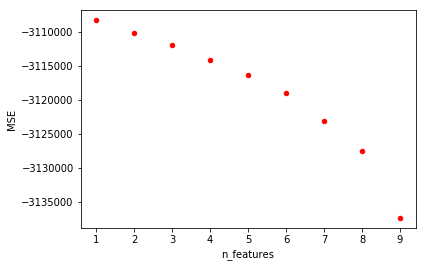

In [27]:
df3 = df2.drop(index=[1022])
df3.plot(kind='scatter',x='n_features',y='MSE',color='red')

In [28]:
features_chosen = df2.loc[266]['features']
features_chosen

('past_3_years_bike_related_purchases',
 'wealth_segment',
 'tenure',
 'property_valuation')

In [29]:
# Obtain features chosen from dataset and train LR 
temp_list = []
for i in features_chosen:
    if i not in X.columns:
        # List of features related to column names
        temp_list += [x for x in X.columns if i in x]
    else:
        temp_list += [i]

est = sm.OLS(y, sm.add_constant(X[temp_list])).fit()

In [30]:
X[temp_list].head()

,past_3_years_bike_related_purchases,wealth_segment,tenure,property_valuation
0,93,3,11.0,10
1,81,3,16.0,10
2,33,3,7.0,9
3,56,1,8.0,4
4,35,2,13.0,9


In [31]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8761
Date:                Tue, 18 Aug 2020   Prob (F-statistic):              0.477
Time:                        18:31:13   Log-Likelihood:                -30325.
No. Observations:                3410   AIC:                         6.066e+04
Df Residuals:                    3405   BIC:                         6.069e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                3092.4743    142.109     21.761      0.000    2813.846    3371.103
past_3_years_bike_related_purchases     1.4697      1.054      1.394      0.163      -0.597       3.536
wealth_segment                          0.7965     36.640      0.022      0.983     -71.042      72.635
tenure                                  1.9721      5.324      0.370      0.711      -8.466      12.410
property_valuation                    -12.9016     10.704     -1.205      0.228     -33.888       8.085
==============================================================================
Omnibus:                      342.021   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              471.610
Skew:                           0.800   Prob(JB):                    3.90e-103
Kurtosis:                       3.872   Cond. No.                         276.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
test = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', 'NewCustomerList', 1)
test

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,state,country,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,...,QLD,Australia,6,0.41,0.5125,0.640625,0.544531,1,1,1.718750
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,...,NSW,Australia,11,0.41,0.4100,0.512500,0.435625,1,1,1.718750
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,...,VIC,Australia,5,0.53,0.5300,0.530000,0.530000,1,1,1.718750
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,...,QLD,Australia,1,0.55,0.6875,0.687500,0.687500,4,4,1.703125
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,...,NSW,Australia,9,0.68,0.6800,0.850000,0.850000,4,4,1.703125
5,Druci,Brandli,Female,39,1951-04-29,Assistant Media Planner,Entertainment,High Net Worth,N,Yes,...,QLD,Australia,7,0.50,0.6250,0.625000,0.625000,6,6,1.671875
6,Rutledge,Hallt,Male,23,1976-10-06,Compensation Analyst,Financial Services,Mass Customer,N,No,...,NSW,Australia,7,0.60,0.6000,0.600000,0.510000,6,6,1.671875
7,Nancie,Vian,Female,74,1972-12-27,Human Resources Assistant II,Retail,Mass Customer,N,Yes,...,QLD,Australia,5,1.04,1.3000,1.300000,1.105000,8,8,1.656250
8,Duff,Karlowicz,Male,50,1972-04-28,Speech Pathologist,Manufacturing,Mass Customer,N,Yes,...,NSW,Australia,10,0.62,0.7750,0.968750,0.823437,8,8,1.656250
9,Barthel,Docket,Male,72,1985-08-02,Accounting Assistant IV,IT,Mass Customer,N,Yes,...,QLD,Australia,5,0.75,0.9375,0.937500,0.796875,10,10,1.640625


In [33]:
test_1 = test[['past_3_years_bike_related_purchases',
 'wealth_segment',
 'tenure',
 'property_valuation']]
test_1.isna().sum()

past_3_years_bike_related_purchases    0
wealth_segment                         0
tenure                                 0
property_valuation                     0
dtype: int64

In [34]:
test_1['wealth_segment']= le_wealth.transform(test_1['wealth_segment'])+1
# Create a set of dummy variables
df_test = test_1.copy()
df_test.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,past_3_years_bike_related_purchases,wealth_segment,tenure,property_valuation
0,86,3,14,6
1,69,3,16,11
2,10,1,10,5
3,64,1,5,1
4,34,1,19,9


In [35]:
predictions = est.predict(sm.add_constant(df_test[temp_list]))

In [36]:
test['Predict'] = predictions
test[['past_3_years_bike_related_purchases','wealth_segment','tenure','property_valuation','Rank','Value','Predict']].sort_values('Predict',ascending=False)

,past_3_years_bike_related_purchases,wealth_segment,tenure,property_valuation,Rank,Value,Predict
224,91,Mass Customer,17,1,223,1.115625,3249.232412
981,83,Affluent Customer,22,1,979,0.416500,3245.742010
683,98,Mass Customer,10,1,684,0.700000,3245.715819
238,84,Mass Customer,15,1,237,1.094375,3235.000183
163,96,High Net Worth,19,3,163,1.182031,3233.925373
108,95,Mass Customer,5,1,104,1.287500,3231.446200
568,81,Mass Customer,14,1,568,0.800000,3228.618929
481,97,Mass Customer,8,2,478,0.880000,3227.400275
513,94,Mass Customer,10,2,513,0.841500,3226.935295
340,93,Affluent Customer,17,3,341,0.990000,3224.775482
